In [1]:
%reload_ext autoreload
%autoreload 2

import os
import logging
import multiprocessing
from pathlib import Path
from tqdm import tqdm

import arviz as az
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns

import numpy as np
import jax
import jax.numpy as jnp
import pandas as pd
import scipy.stats as stats
import numpyro
from numpyro.diagnostics import hpdi

from hbmep.config import Config
from hbmep_paper.simulator import HierarchicalBayesianModel
from hbmep.model.utils import Site as site

PLATFORM = "cpu"
jax.config.update("jax_platforms", PLATFORM)
numpyro.set_platform(PLATFORM)

cpu_count = multiprocessing.cpu_count() - 2
numpyro.set_host_device_count(cpu_count)
numpyro.enable_x64()
numpyro.enable_validation()

logger = logging.getLogger(__name__)


In [2]:
root_path = Path(os.getcwd()).parent.parent.parent.absolute()
toml_path = os.path.join(root_path, "configs/simulation.toml")

config = Config(toml_path=toml_path)

model = HierarchicalBayesianModel(config=config)



2023-09-14 19:16:39,414 - hbmep.config - INFO - Verifying configuration ...
2023-09-14 19:16:39,415 - hbmep.config - INFO - Success!
2023-09-14 19:16:39,427 - hbmep.model.baseline - INFO - Initialized model with hierarchical_bayesian link


In [3]:
# Load data
simulation_params = {
    "n_subject": 6,
    "n_feature0": 1,
    "n_draws": 5,
    "n_repeats": 10
}

df_full, posterior_samples_true = model.simulate(**simulation_params)

obs = np.array(posterior_samples_true[site.obs])


2023-09-14 19:16:39,462 - hbmep.model.baseline - INFO - Simulating data ...


2023-09-14 19:16:41,815 - hbmep.utils.utils - INFO - func:predict took: 2.35 sec
2023-09-14 19:16:41,816 - hbmep.utils.utils - INFO - func:simulate took: 2.35 sec


In [4]:
subdir = "checks-3"

x_space = df_full[model.intensity].unique()

N_space = [15, 30, 45, 60, 75, 90]
m_space = [1, 3, 5, 10]

# N_space = [15, 30]
# m_space = [1]

scores = []
err_mae = []
err_mse = []

N_space_counter = 0
m_space_counter = 0

draw_ind = 0

for m_ind, m in enumerate(m_space):
    curr_scores = []
    curr_mae = []
    curr_mse = []

    for N_ind, N in enumerate(N_space):
        logger.info(f"N: {N}, m: {m}")
        N_eff = N // m

        ind = np.round(np.linspace(0, x_space.shape[0] - 1, N_eff)).astype(int)
        ind = df_full[model.intensity].isin(x_space[ind])
        df = df_full[ind].reset_index(drop=True).copy()

        for muscle_ind, muscle in enumerate(model.response):
            reponse_columns = [muscle + f"{i:02}" for i in range(m)]
            df[reponse_columns] = obs[..., :m, ind, muscle_ind][draw_ind, ...].T

        df["id"] = df.index
        df = pd.wide_to_long(df, stubnames=model.response, i="id", j="var_name").reset_index(drop=True)

        """ Build model """
        config = Config(toml_path=toml_path)
        model = HierarchicalBayesianModel(config=config)
        model.recruitment_curves_path = os.path.join(model.build_dir, subdir, f"rec_m{m:02}_N{N:02}.pdf")
        model.posterior_predictive_path = os.path.join(model.build_dir, subdir, f"ppd_m{m:02}_N{N:02}.pdf")

        """ Load """
        df, encoder_dict = model.load(df=df)

        """ Fit """
        mcmc, posterior_samples = model.run_inference(df=df)

        """ Plot """
        model.render_recruitment_curves(df=df, encoder_dict=encoder_dict, posterior_samples=posterior_samples)
        model.render_predictive_check(df=df, encoder_dict=encoder_dict, posterior_samples=posterior_samples)

        """ Threshold """
        threshold = posterior_samples[site.a].mean(axis=0)
        threshold_true = posterior_samples_true[site.a][draw_ind, ...]

        """ Scores """
        mae = np.abs(threshold - threshold_true)
        mse = (mae ** 2).mean(axis=-1).reshape(-1,).tolist()
        mae = mae.mean(axis=-1).reshape(-1,).tolist()

        numpyro_data = az.from_numpyro(mcmc)
        loo_score = az.loo(numpyro_data).elpd_loo
        waic_score = az.waic(numpyro_data).elpd_waic

        scores_row = [loo_score, waic_score]
        curr_scores.append(scores_row)
        curr_mae.append(mae)
        curr_mse.append(mse)

    scores.append(curr_scores)
    err_mae.append(curr_mae)
    err_mse.append(curr_mse)

scores = np.array(scores)
err_mae = np.array(err_mae)
err_mse = np.array(err_mse)


2023-09-14 19:16:41,829 - __main__ - INFO - N: 15, m: 1
2023-09-14 19:16:41,837 - hbmep.config - INFO - Verifying configuration ...
2023-09-14 19:16:41,837 - hbmep.config - INFO - Success!
2023-09-14 19:16:41,837 - hbmep.model.baseline - INFO - Initialized model with hierarchical_bayesian link
2023-09-14 19:16:41,838 - hbmep.dataset.core - INFO - Artefacts will be stored here - /home/vishu/repos/hbmep-paper/reports/simulation/
2023-09-14 19:16:41,838 - hbmep.dataset.core - INFO - Copied config to /home/vishu/repos/hbmep-paper/reports/simulation/
2023-09-14 19:16:41,838 - hbmep.dataset.core - INFO - Processing data ...
2023-09-14 19:16:41,839 - hbmep.utils.utils - INFO - func:load took: 0.00 sec
2023-09-14 19:16:41,840 - hbmep.model.baseline - INFO - Running inference with hierarchical_bayesian ...


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 19:20:48,216 - hbmep.utils.utils - INFO - func:run_inference took: 4 min and 6.38 sec
2023-09-14 19:20:48,217 - hbmep.model.baseline - INFO - Generating predictions ...
2023-09-14 19:21:04,259 - hbmep.utils.utils - INFO - func:predict took: 16.04 sec
2023-09-14 19:21:04,320 - hbmep.model.baseline - INFO - Rendering recruitment curves ...
2023-09-14 19:21:09,495 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/simulation/checks-3/rec_m01_N15.pdf
2023-09-14 19:21:09,496 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 21.28 sec
2023-09-14 19:21:09,496 - hbmep.model.baseline - INFO - Generating predictions ...
2023-09-14 19:21:25,401 - hbmep.utils.utils - INFO - func:predict took: 15.90 sec
2023-09-14 19:21:25,505 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-14 19:21:35,629 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/simulation/checks-3/ppd_m01_N15.pdf
2023-09-1

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 19:27:48,242 - hbmep.utils.utils - INFO - func:run_inference took: 6 min and 10.36 sec
2023-09-14 19:27:48,242 - hbmep.model.baseline - INFO - Generating predictions ...
2023-09-14 19:28:04,215 - hbmep.utils.utils - INFO - func:predict took: 15.97 sec
2023-09-14 19:28:04,273 - hbmep.model.baseline - INFO - Rendering recruitment curves ...
2023-09-14 19:28:09,557 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/simulation/checks-3/rec_m01_N30.pdf
2023-09-14 19:28:09,558 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 21.32 sec
2023-09-14 19:28:09,558 - hbmep.model.baseline - INFO - Generating predictions ...
2023-09-14 19:28:25,487 - hbmep.utils.utils - INFO - func:predict took: 15.93 sec
2023-09-14 19:28:25,611 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-14 19:28:35,834 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/simulation/checks-3/ppd_m01_N30.pdf
2023-09-

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 19:43:06,856 - hbmep.utils.utils - INFO - func:run_inference took: 14 min and 28.55 sec
2023-09-14 19:43:06,857 - hbmep.model.baseline - INFO - Generating predictions ...
2023-09-14 19:43:22,972 - hbmep.utils.utils - INFO - func:predict took: 16.11 sec
2023-09-14 19:43:23,031 - hbmep.model.baseline - INFO - Rendering recruitment curves ...
2023-09-14 19:43:28,892 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/simulation/checks-3/rec_m01_N45.pdf
2023-09-14 19:43:28,892 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 22.04 sec
2023-09-14 19:43:28,892 - hbmep.model.baseline - INFO - Generating predictions ...
2023-09-14 19:43:44,951 - hbmep.utils.utils - INFO - func:predict took: 16.06 sec
2023-09-14 19:43:45,054 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-14 19:43:55,563 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/simulation/checks-3/ppd_m01_N45.pdf
2023-09

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 20:03:49,879 - hbmep.utils.utils - INFO - func:run_inference took: 19 min and 51.07 sec
2023-09-14 20:03:49,880 - hbmep.model.baseline - INFO - Generating predictions ...
2023-09-14 20:04:05,976 - hbmep.utils.utils - INFO - func:predict took: 16.09 sec
2023-09-14 20:04:06,037 - hbmep.model.baseline - INFO - Rendering recruitment curves ...
2023-09-14 20:04:12,014 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/simulation/checks-3/rec_m01_N60.pdf
2023-09-14 20:04:12,015 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 22.13 sec
2023-09-14 20:04:12,015 - hbmep.model.baseline - INFO - Generating predictions ...
2023-09-14 20:04:28,095 - hbmep.utils.utils - INFO - func:predict took: 16.08 sec
2023-09-14 20:04:28,198 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-14 20:04:38,765 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/simulation/checks-3/ppd_m01_N60.pdf
2023-09

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 20:30:30,037 - hbmep.utils.utils - INFO - func:run_inference took: 25 min and 45.28 sec
2023-09-14 20:30:30,038 - hbmep.model.baseline - INFO - Generating predictions ...
2023-09-14 20:30:46,183 - hbmep.utils.utils - INFO - func:predict took: 16.14 sec
2023-09-14 20:30:46,241 - hbmep.model.baseline - INFO - Rendering recruitment curves ...
2023-09-14 20:30:51,987 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/simulation/checks-3/rec_m01_N75.pdf
2023-09-14 20:30:51,988 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 21.95 sec
2023-09-14 20:30:51,988 - hbmep.model.baseline - INFO - Generating predictions ...
2023-09-14 20:31:08,099 - hbmep.utils.utils - INFO - func:predict took: 16.11 sec
2023-09-14 20:31:08,203 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-14 20:31:18,827 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/simulation/checks-3/ppd_m01_N75.pdf
2023-09

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 21:02:02,951 - hbmep.utils.utils - INFO - func:run_inference took: 30 min and 38.91 sec
2023-09-14 21:02:02,952 - hbmep.model.baseline - INFO - Generating predictions ...
2023-09-14 21:02:19,074 - hbmep.utils.utils - INFO - func:predict took: 16.12 sec
2023-09-14 21:02:19,133 - hbmep.model.baseline - INFO - Rendering recruitment curves ...
2023-09-14 21:02:24,988 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/simulation/checks-3/rec_m01_N90.pdf
2023-09-14 21:02:24,989 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 22.04 sec
2023-09-14 21:02:24,989 - hbmep.model.baseline - INFO - Generating predictions ...
2023-09-14 21:02:41,015 - hbmep.utils.utils - INFO - func:predict took: 16.02 sec
2023-09-14 21:02:41,117 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-14 21:02:51,970 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/simulation/checks-3/ppd_m01_N90.pdf
2023-09

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 21:08:45,166 - hbmep.utils.utils - INFO - func:run_inference took: 5 min and 47.04 sec
2023-09-14 21:08:45,167 - hbmep.model.baseline - INFO - Generating predictions ...
2023-09-14 21:09:01,207 - hbmep.utils.utils - INFO - func:predict took: 16.04 sec
2023-09-14 21:09:01,266 - hbmep.model.baseline - INFO - Rendering recruitment curves ...
2023-09-14 21:09:06,767 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/simulation/checks-3/rec_m03_N15.pdf
2023-09-14 21:09:06,768 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 21.60 sec
2023-09-14 21:09:06,768 - hbmep.model.baseline - INFO - Generating predictions ...
2023-09-14 21:09:22,865 - hbmep.utils.utils - INFO - func:predict took: 16.09 sec
2023-09-14 21:09:22,968 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-14 21:09:33,588 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/simulation/checks-3/ppd_m03_N15.pdf
2023-09-

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 21:18:03,279 - hbmep.utils.utils - INFO - func:run_inference took: 8 min and 28.47 sec
2023-09-14 21:18:03,279 - hbmep.model.baseline - INFO - Generating predictions ...
2023-09-14 21:18:19,343 - hbmep.utils.utils - INFO - func:predict took: 16.06 sec
2023-09-14 21:18:19,403 - hbmep.model.baseline - INFO - Rendering recruitment curves ...
2023-09-14 21:18:25,417 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/simulation/checks-3/rec_m03_N30.pdf
2023-09-14 21:18:25,417 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 22.14 sec
2023-09-14 21:18:25,417 - hbmep.model.baseline - INFO - Generating predictions ...
2023-09-14 21:18:41,468 - hbmep.utils.utils - INFO - func:predict took: 16.05 sec
2023-09-14 21:18:41,570 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-14 21:18:52,631 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/simulation/checks-3/ppd_m03_N30.pdf
2023-09-

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 21:34:08,161 - hbmep.utils.utils - INFO - func:run_inference took: 15 min and 13.32 sec
2023-09-14 21:34:08,162 - hbmep.model.baseline - INFO - Generating predictions ...
2023-09-14 21:34:24,271 - hbmep.utils.utils - INFO - func:predict took: 16.10 sec
2023-09-14 21:34:24,331 - hbmep.model.baseline - INFO - Rendering recruitment curves ...
2023-09-14 21:34:30,443 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/simulation/checks-3/rec_m03_N45.pdf
2023-09-14 21:34:30,443 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 22.28 sec
2023-09-14 21:34:30,443 - hbmep.model.baseline - INFO - Generating predictions ...
2023-09-14 21:34:46,508 - hbmep.utils.utils - INFO - func:predict took: 16.06 sec
2023-09-14 21:34:46,612 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-14 21:34:57,281 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/simulation/checks-3/ppd_m03_N45.pdf
2023-09

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 21:52:46,370 - hbmep.utils.utils - INFO - func:run_inference took: 17 min and 45.91 sec
2023-09-14 21:52:46,371 - hbmep.model.baseline - INFO - Generating predictions ...
2023-09-14 21:53:02,402 - hbmep.utils.utils - INFO - func:predict took: 16.03 sec
2023-09-14 21:53:02,461 - hbmep.model.baseline - INFO - Rendering recruitment curves ...
2023-09-14 21:53:08,474 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/simulation/checks-3/rec_m03_N60.pdf
2023-09-14 21:53:08,474 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 22.10 sec
2023-09-14 21:53:08,474 - hbmep.model.baseline - INFO - Generating predictions ...
2023-09-14 21:53:24,523 - hbmep.utils.utils - INFO - func:predict took: 16.05 sec
2023-09-14 21:53:24,653 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-14 21:53:35,453 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/simulation/checks-3/ppd_m03_N60.pdf
2023-09

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 22:21:01,855 - hbmep.utils.utils - INFO - func:run_inference took: 27 min and 22.32 sec
2023-09-14 22:21:01,857 - hbmep.model.baseline - INFO - Generating predictions ...
2023-09-14 22:21:17,967 - hbmep.utils.utils - INFO - func:predict took: 16.11 sec
2023-09-14 22:21:18,027 - hbmep.model.baseline - INFO - Rendering recruitment curves ...
2023-09-14 22:21:24,082 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/simulation/checks-3/rec_m03_N75.pdf
2023-09-14 22:21:24,082 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 22.23 sec
2023-09-14 22:21:24,082 - hbmep.model.baseline - INFO - Generating predictions ...
2023-09-14 22:21:40,139 - hbmep.utils.utils - INFO - func:predict took: 16.05 sec
2023-09-14 22:21:40,241 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-14 22:21:50,975 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/simulation/checks-3/ppd_m03_N75.pdf
2023-09

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 22:52:16,658 - hbmep.utils.utils - INFO - func:run_inference took: 30 min and 16.27 sec
2023-09-14 22:52:16,659 - hbmep.model.baseline - INFO - Generating predictions ...
2023-09-14 22:52:32,726 - hbmep.utils.utils - INFO - func:predict took: 16.06 sec
2023-09-14 22:52:32,785 - hbmep.model.baseline - INFO - Rendering recruitment curves ...
2023-09-14 22:52:38,463 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/simulation/checks-3/rec_m03_N90.pdf
2023-09-14 22:52:38,463 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 21.80 sec
2023-09-14 22:52:38,463 - hbmep.model.baseline - INFO - Generating predictions ...
2023-09-14 22:52:54,511 - hbmep.utils.utils - INFO - func:predict took: 16.04 sec
2023-09-14 22:52:54,614 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-14 22:53:05,456 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/simulation/checks-3/ppd_m03_N90.pdf
2023-09

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 22:59:06,394 - hbmep.utils.utils - INFO - func:run_inference took: 5 min and 54.86 sec
2023-09-14 22:59:06,395 - hbmep.model.baseline - INFO - Generating predictions ...
2023-09-14 22:59:22,394 - hbmep.utils.utils - INFO - func:predict took: 15.99 sec
2023-09-14 22:59:22,453 - hbmep.model.baseline - INFO - Rendering recruitment curves ...
2023-09-14 22:59:27,737 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/simulation/checks-3/rec_m05_N15.pdf
2023-09-14 22:59:27,737 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 21.34 sec
2023-09-14 22:59:27,738 - hbmep.model.baseline - INFO - Generating predictions ...
2023-09-14 22:59:43,726 - hbmep.utils.utils - INFO - func:predict took: 15.99 sec
2023-09-14 22:59:43,830 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-14 22:59:54,592 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/simulation/checks-3/ppd_m05_N15.pdf
2023-09-

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 23:12:01,939 - hbmep.utils.utils - INFO - func:run_inference took: 12 min and 6.05 sec
2023-09-14 23:12:01,940 - hbmep.model.baseline - INFO - Generating predictions ...
2023-09-14 23:12:18,012 - hbmep.utils.utils - INFO - func:predict took: 16.07 sec
2023-09-14 23:12:18,072 - hbmep.model.baseline - INFO - Rendering recruitment curves ...
2023-09-14 23:12:23,942 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/simulation/checks-3/rec_m05_N30.pdf
2023-09-14 23:12:23,943 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 22.00 sec
2023-09-14 23:12:23,943 - hbmep.model.baseline - INFO - Generating predictions ...
2023-09-14 23:12:39,979 - hbmep.utils.utils - INFO - func:predict took: 16.03 sec
2023-09-14 23:12:40,082 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-14 23:12:50,494 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/simulation/checks-3/ppd_m05_N30.pdf
2023-09-

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 23:27:06,968 - hbmep.utils.utils - INFO - func:run_inference took: 14 min and 13.88 sec
2023-09-14 23:27:06,969 - hbmep.model.baseline - INFO - Generating predictions ...
2023-09-14 23:27:23,027 - hbmep.utils.utils - INFO - func:predict took: 16.05 sec
2023-09-14 23:27:23,087 - hbmep.model.baseline - INFO - Rendering recruitment curves ...
2023-09-14 23:27:28,529 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/simulation/checks-3/rec_m05_N45.pdf
2023-09-14 23:27:28,529 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 21.56 sec
2023-09-14 23:27:28,530 - hbmep.model.baseline - INFO - Generating predictions ...
2023-09-14 23:27:44,522 - hbmep.utils.utils - INFO - func:predict took: 15.99 sec
2023-09-14 23:27:44,627 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-14 23:27:55,392 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/simulation/checks-3/ppd_m05_N45.pdf
2023-09

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-14 23:49:16,075 - hbmep.utils.utils - INFO - func:run_inference took: 21 min and 16.94 sec
2023-09-14 23:49:16,076 - hbmep.model.baseline - INFO - Generating predictions ...
2023-09-14 23:49:32,137 - hbmep.utils.utils - INFO - func:predict took: 16.06 sec
2023-09-14 23:49:32,197 - hbmep.model.baseline - INFO - Rendering recruitment curves ...
2023-09-14 23:49:37,779 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/simulation/checks-3/rec_m05_N60.pdf
2023-09-14 23:49:37,779 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 21.70 sec
2023-09-14 23:49:37,780 - hbmep.model.baseline - INFO - Generating predictions ...
2023-09-14 23:49:53,848 - hbmep.utils.utils - INFO - func:predict took: 16.07 sec
2023-09-14 23:49:53,950 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-14 23:50:04,732 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/simulation/checks-3/ppd_m05_N60.pdf
2023-09

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-15 00:15:12,029 - hbmep.utils.utils - INFO - func:run_inference took: 25 min and 3.17 sec
2023-09-15 00:15:12,030 - hbmep.model.baseline - INFO - Generating predictions ...
2023-09-15 00:15:28,088 - hbmep.utils.utils - INFO - func:predict took: 16.05 sec
2023-09-15 00:15:28,148 - hbmep.model.baseline - INFO - Rendering recruitment curves ...
2023-09-15 00:15:34,254 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/simulation/checks-3/rec_m05_N75.pdf
2023-09-15 00:15:34,254 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 22.22 sec
2023-09-15 00:15:34,254 - hbmep.model.baseline - INFO - Generating predictions ...
2023-09-15 00:15:50,301 - hbmep.utils.utils - INFO - func:predict took: 16.04 sec
2023-09-15 00:15:50,404 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-15 00:16:01,319 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/simulation/checks-3/ppd_m05_N75.pdf
2023-09-

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-15 00:47:31,474 - hbmep.utils.utils - INFO - func:run_inference took: 31 min and 25.07 sec
2023-09-15 00:47:31,475 - hbmep.model.baseline - INFO - Generating predictions ...
2023-09-15 00:47:47,522 - hbmep.utils.utils - INFO - func:predict took: 16.04 sec
2023-09-15 00:47:47,584 - hbmep.model.baseline - INFO - Rendering recruitment curves ...
2023-09-15 00:47:53,254 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/simulation/checks-3/rec_m05_N90.pdf
2023-09-15 00:47:53,254 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 21.78 sec
2023-09-15 00:47:53,254 - hbmep.model.baseline - INFO - Generating predictions ...
2023-09-15 00:48:09,277 - hbmep.utils.utils - INFO - func:predict took: 16.02 sec
2023-09-15 00:48:09,379 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-15 00:48:20,250 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/simulation/checks-3/ppd_m05_N90.pdf
2023-09

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-15 00:49:30,227 - hbmep.utils.utils - INFO - func:run_inference took: 1 min and 3.86 sec
2023-09-15 00:49:30,228 - hbmep.model.baseline - INFO - Generating predictions ...
2023-09-15 00:49:47,168 - hbmep.utils.utils - INFO - func:predict took: 16.94 sec
2023-09-15 00:49:47,227 - hbmep.model.baseline - INFO - Rendering recruitment curves ...
2023-09-15 00:49:52,100 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/simulation/checks-3/rec_m10_N15.pdf
2023-09-15 00:49:52,100 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 21.87 sec
2023-09-15 00:49:52,100 - hbmep.model.baseline - INFO - Generating predictions ...
2023-09-15 00:50:08,113 - hbmep.utils.utils - INFO - func:predict took: 16.01 sec
2023-09-15 00:50:08,214 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-15 00:50:18,241 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/simulation/checks-3/ppd_m10_N15.pdf
2023-09-1

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-15 01:01:37,347 - hbmep.utils.utils - INFO - func:run_inference took: 11 min and 16.69 sec
2023-09-15 01:01:37,348 - hbmep.model.baseline - INFO - Generating predictions ...
2023-09-15 01:01:53,401 - hbmep.utils.utils - INFO - func:predict took: 16.05 sec
2023-09-15 01:01:53,460 - hbmep.model.baseline - INFO - Rendering recruitment curves ...
2023-09-15 01:01:58,907 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/simulation/checks-3/rec_m10_N30.pdf
2023-09-15 01:01:58,908 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 21.56 sec
2023-09-15 01:01:58,908 - hbmep.model.baseline - INFO - Generating predictions ...
2023-09-15 01:02:14,941 - hbmep.utils.utils - INFO - func:predict took: 16.03 sec
2023-09-15 01:02:15,037 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-15 01:02:25,875 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/simulation/checks-3/ppd_m10_N30.pdf
2023-09

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-15 01:17:08,044 - hbmep.utils.utils - INFO - func:run_inference took: 14 min and 39.93 sec
2023-09-15 01:17:08,045 - hbmep.model.baseline - INFO - Generating predictions ...
2023-09-15 01:17:24,131 - hbmep.utils.utils - INFO - func:predict took: 16.08 sec
2023-09-15 01:17:24,192 - hbmep.model.baseline - INFO - Rendering recruitment curves ...
2023-09-15 01:17:30,096 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/simulation/checks-3/rec_m10_N45.pdf
2023-09-15 01:17:30,096 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 22.05 sec
2023-09-15 01:17:30,097 - hbmep.model.baseline - INFO - Generating predictions ...
2023-09-15 01:17:46,126 - hbmep.utils.utils - INFO - func:predict took: 16.03 sec
2023-09-15 01:17:46,230 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-15 01:17:57,180 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/simulation/checks-3/ppd_m10_N45.pdf
2023-09

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-15 01:40:10,690 - hbmep.utils.utils - INFO - func:run_inference took: 22 min and 10.22 sec
2023-09-15 01:40:10,691 - hbmep.model.baseline - INFO - Generating predictions ...
2023-09-15 01:40:26,737 - hbmep.utils.utils - INFO - func:predict took: 16.04 sec
2023-09-15 01:40:26,797 - hbmep.model.baseline - INFO - Rendering recruitment curves ...
2023-09-15 01:40:32,905 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/simulation/checks-3/rec_m10_N60.pdf
2023-09-15 01:40:32,906 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 22.21 sec
2023-09-15 01:40:32,906 - hbmep.model.baseline - INFO - Generating predictions ...
2023-09-15 01:40:48,916 - hbmep.utils.utils - INFO - func:predict took: 16.01 sec
2023-09-15 01:40:49,019 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-15 01:40:59,438 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/simulation/checks-3/ppd_m10_N60.pdf
2023-09

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-15 02:04:12,199 - hbmep.utils.utils - INFO - func:run_inference took: 23 min and 8.71 sec
2023-09-15 02:04:12,200 - hbmep.model.baseline - INFO - Generating predictions ...
2023-09-15 02:04:28,334 - hbmep.utils.utils - INFO - func:predict took: 16.13 sec
2023-09-15 02:04:28,393 - hbmep.model.baseline - INFO - Rendering recruitment curves ...
2023-09-15 02:04:33,849 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/simulation/checks-3/rec_m10_N75.pdf
2023-09-15 02:04:33,849 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 21.65 sec
2023-09-15 02:04:33,850 - hbmep.model.baseline - INFO - Generating predictions ...
2023-09-15 02:04:49,896 - hbmep.utils.utils - INFO - func:predict took: 16.04 sec
2023-09-15 02:04:49,998 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-15 02:05:01,159 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/simulation/checks-3/ppd_m10_N75.pdf
2023-09-

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [9]:
err_mae.shape

(2, 3, 2)

In [15]:
err_mae_mean = err_mae.mean(axis=-1)
err_mse_mean = err_mse.mean(axis=-1)

In [11]:
err_mae_mean.shape

(2, 3)

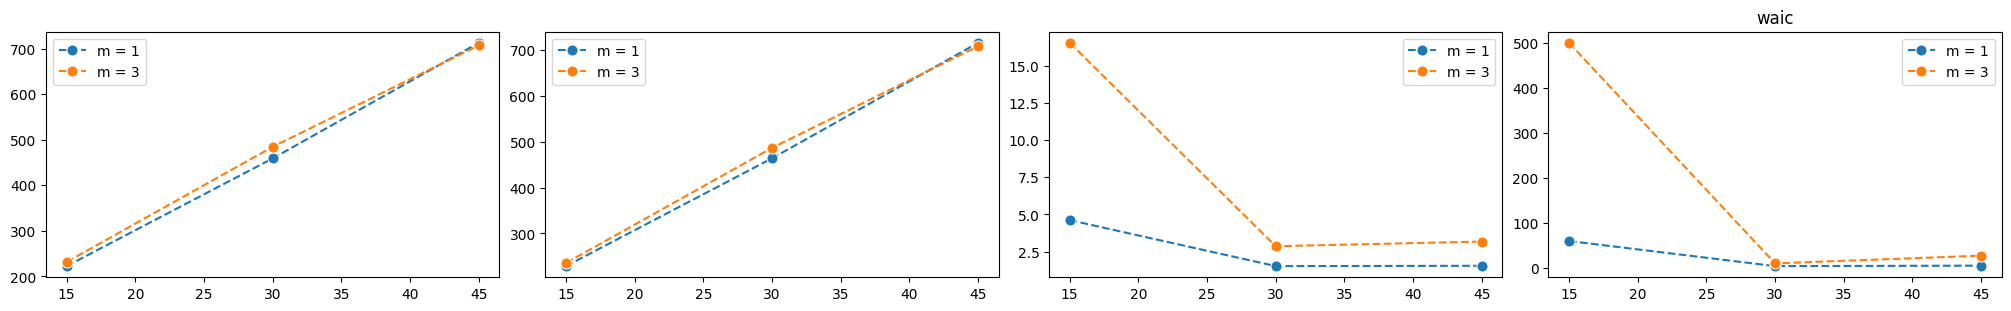

In [16]:
nrows, ncols = 1, 4
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 3 * nrows), squeeze=False, constrained_layout=True, sharex="row")

metrics = ["loo", "waic"]
for j, m in enumerate(m_space):
    for i, metric in enumerate(metrics):
        ax = axes[0, i]
        sns.lineplot(x=N_space, y=scores[j, ..., i], marker="o", linestyle="dashed", ms=8, ax=ax, label=f"m = {m}")

    ax = axes[0, 2]
    sns.lineplot(x=N_space, y=err_mae_mean[j, ...], marker="o", linestyle="dashed", ms=8, ax=ax, label=f"m = {m}")

    ax = axes[0, 3]
    sns.lineplot(x=N_space, y=err_mse_mean[j, ...], marker="o", linestyle="dashed", ms=8, ax=ax, label=f"m = {m}")

for i, metric in enumerate(metrics):
    ax.set_title(metric)






In [8]:
scores.shape

(1, 3, 4)

In [9]:
posterior_samples_true[site.a].shape

(5, 2, 3, 3)

In [37]:
pred_df

,participant,compound_position,pulse_amplitude
0,0,0,0.000000
1,0,0,3.636364
2,0,0,7.272727
3,0,0,10.909091
4,0,0,14.545455
...,...,...,...
95,0,0,345.454545
96,0,0,349.090909
97,0,0,352.727273
98,0,0,356.363636


In [35]:
mu_posterior.shape

(24000, 100, 3)

In [34]:
hpdi_mu_95[0, ...]

(2, 100, 3)

In [33]:
threshold_posterior.shape

(24000, 1, 1, 3)

In [32]:
threshold.shape

(1, 1, 3)

In [31]:
hpdi_interval[0, ..., 0].shape

(1, 1)

In [25]:
curr_mu_posterior_mean.shape

(100, 3)

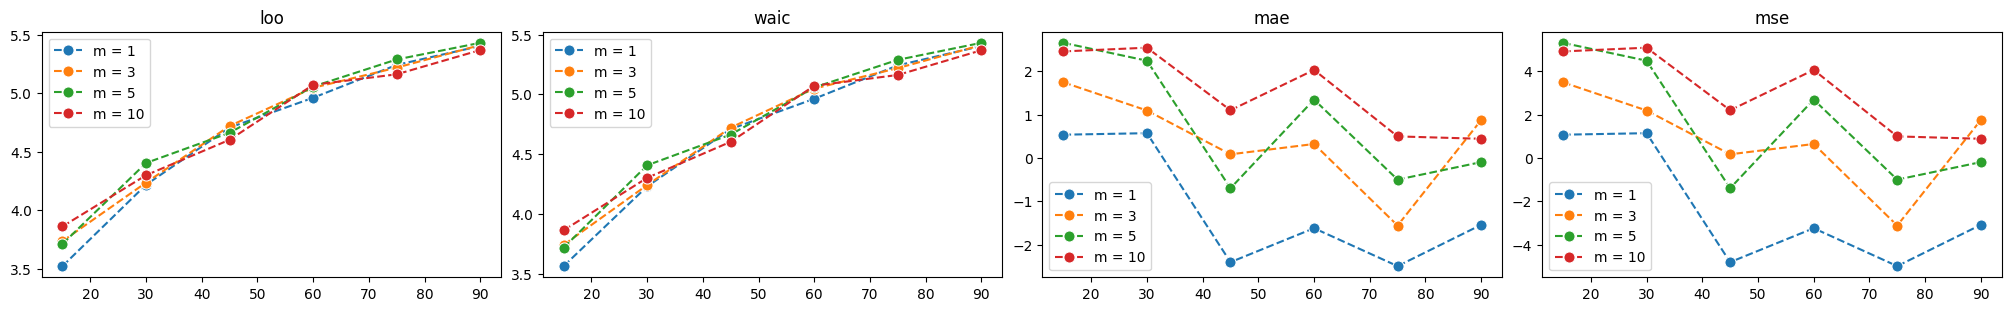

In [ ]:
nrows, ncols = 1, 4
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 3 * nrows), squeeze=False, constrained_layout=True, sharex="row")

metrics = ["loo", "waic", "mae", "mse"]
for i, metric in enumerate(metrics):
    ax = axes[0, i]
    for j, m in enumerate(m_space):
        sns.lineplot(x=N_space, y=np.log(scores[j, ..., i]), marker="o", linestyle="dashed", ms=8, ax=ax, label=f"m = {m}")
    ax.set_title(metric)

3

In [24]:
np.abs(posterior_samples[site.a].mean(axis=0) - predictions[site.a][0, ...]).mean() 

6.061084977897591

In [12]:
hpdi_mu_95.shape

(2, 100, 3)

In [16]:
predictions[site.a][0, ...].shape

(1, 1, 3)

In [9]:
posterior_samples[site.a].mean(axis=0).shape

(1, 1, 3)

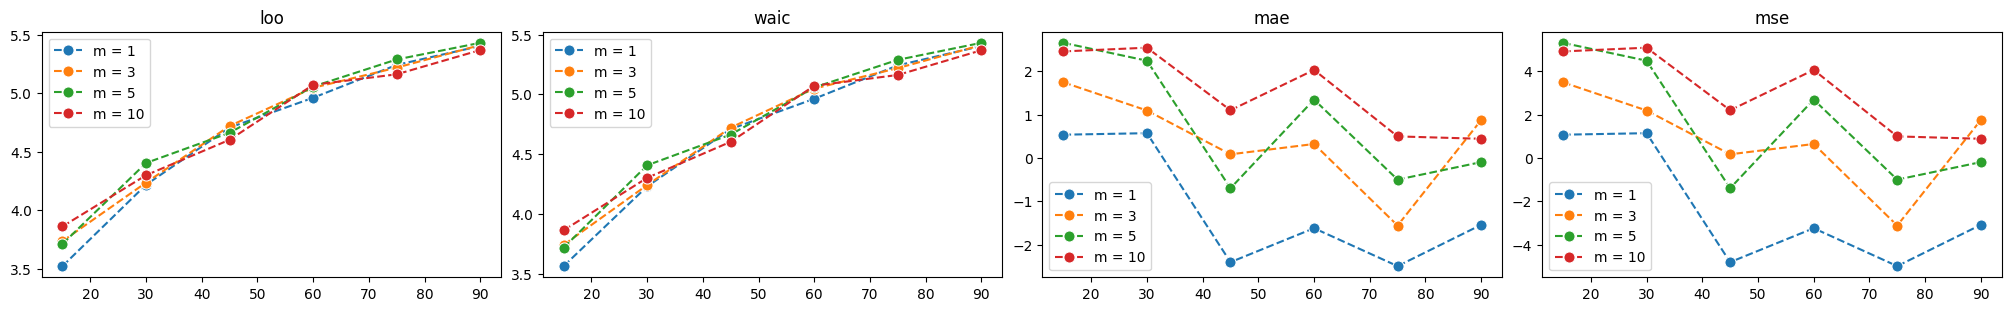

In [20]:
nrows, ncols = 1, 4
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 3 * nrows), squeeze=False, constrained_layout=True, sharex="row")

metrics = ["loo", "waic", "mae", "mse"]
for i, metric in enumerate(metrics):
    ax = axes[0, i]
    for j, m in enumerate(m_space):
        sns.lineplot(x=N_space, y=np.log(scores[j, ..., i]), marker="o", linestyle="dashed", ms=8, ax=ax, label=f"m = {m}")
    ax.set_title(metric)

In [55]:
scores = np.array(scores)

In [71]:
posterior_samples_true[site.b].shape

(10, 1, 1, 1)

In [ ]:
fig, axes = 

<Axes: >

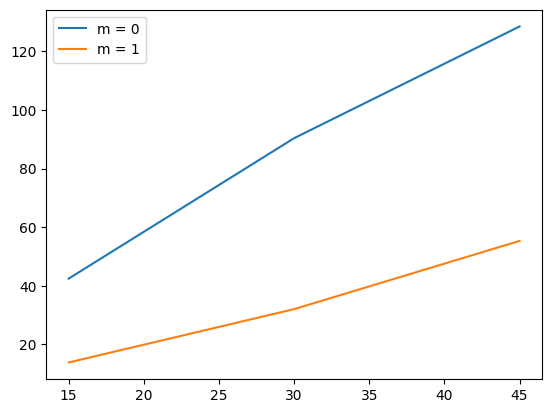

In [57]:
m = 0
sns.lineplot(x=N_space, y=scores[0, ..., m], label=f"m = {m}")

m = 1
sns.lineplot(x=N_space, y=scores[1, ..., m], label=f"m = {m}")

In [39]:
curr_scores

[[42.44940147116906, 43.18916559657801, 2.8651050168656127, 8.208826757668502]]

In [152]:
ind = [0, 30, 60, 89]
n_iter = 9
n_after_every_space = n_iter + 1
after_every_counter = 0

n_fig_rows = 10
n_columns_per_response = 4
n_fig_columns = n_columns_per_response * model.n_response

n_combinations = n_iter + 1
n_pdf_pages = n_combinations // n_fig_rows
if n_combinations % n_fig_rows: n_pdf_pages += 1

dst = os.path.join(model.build_dir, "checks.pdf")
pdf = PdfPages(dst)

argmin = None
score_df = None
score_columns = ["num_points", "loo", "waic", "mae", "mse"]

for page in range(n_pdf_pages):
    """ No. of rows for current page """
    n_rows_current_page = min(
        n_fig_rows,
        n_combinations - page * n_fig_rows
    )

    """ Figure for current page """
    fig, axes = plt.subplots(
        n_rows_current_page,
        n_fig_columns,
        figsize=(
            n_fig_columns * model.subplot_cell_width,
            n_rows_current_page * model.subplot_cell_height
        ),
        constrained_layout=True,
        squeeze=False,
        sharex="col"
    )

    for i in range(n_rows_current_page):
        df = df_full.iloc[ind].reset_index(drop=True).copy()
        logger.info(df.shape)

        df, encoder_dict = model.load(df=df)

        ax = axes[i, 0]
        sns.scatterplot(x=df[model.intensity], y=df[model.response[0]], ax=ax)
        if argmin is not None:
            sns.scatterplot(
                x=[df_full[model.intensity][argmin]],
                y=[df_full[model.response[0]][argmin]],
                color="black",
                edgecolor="black",
                ax=ax
            )
        title = f"Num points: {df.shape[0]}"
        ax.set_title(title)

        mcmc, posterior_samples = model.run_inference(df=df)

        pred_df = model._make_prediction_dataset(df=df)
        obs_posterior = model.predict(df=pred_df, posterior_samples=posterior_samples)
        mu_posterior = np.array(obs_posterior[site.mu])
        obs_posterior = np.array(obs_posterior[site.obs])

        """ Filter prediction dataframe based on current combination """
        temp_pred_df = pred_df.copy()

        curr_obs_posterior = obs_posterior
        curr_mu_posterior = mu_posterior

        """ Posterior mean """
        curr_obs_posterior_mean = curr_obs_posterior.mean(axis=0)
        curr_mu_posterior_mean = curr_mu_posterior.mean(axis=0)

        """ HPDI intervals """
        hpdi_obs_95 = hpdi(curr_obs_posterior, prob=.95)
        hpdi_obs_85 = hpdi(curr_obs_posterior, prob=.85)
        hpdi_obs_65 = hpdi(curr_obs_posterior, prob=.65)

        hpdi_mu_95 = hpdi(curr_mu_posterior, prob=.95)

        """ Threshold """
        threshold_posterior = posterior_samples[site.a].reshape(-1,)
        threshold = threshold_posterior.mean().item()
        threshold_true = posterior_samples_true[site.a][0].reshape(-1,).item()
        hpdi_interval = hpdi(threshold_posterior, prob=0.95)

        """ Scores """
        numpyro_data = az.from_numpyro(mcmc)
        loo_score = az.loo(numpyro_data).elpd_loo
        waic_score = az.waic(numpyro_data).elpd_waic
        mae = abs(threshold_true - threshold)
        mse = mae ** 2

        ax = axes[i, 1]
        sns.lineplot(x=temp_pred_df[model.intensity], y=curr_obs_posterior_mean[:, 0], color="k", ax=ax, linestyle="dashed")
        sns.scatterplot(x=df[model.intensity], y=df[model.response[0]], ax=ax)
        if argmin is not None:
            sns.scatterplot(
                x=[df_full[model.intensity][argmin]],
                y=[df_full[model.response[0]][argmin]],
                color="black",
                edgecolor="black",
                ax=ax
            )
        ax.axvline(
            threshold,
            linestyle="--",
            color="r",
            label=f"Predicted Threshold"
        )
        ax.axvline(
            threshold_true,
            linestyle="--",
            color="g",
            label=f"Actual Threshold"
        )
        ax.legend()

        ax = axes[i, 2]
        sns.kdeplot(
            x=threshold_posterior,
            color="b",
            ax=ax,
            alpha=.4
        )
        ax.axvline(
            threshold,
            linestyle="--",
            color="r",
            label=f"Predicted Threshold"
        )
        ax.axvline(
            threshold_true,
            linestyle="--",
            color="g",
            label=f"Actual Threshold"
        )
        ax.legend()

        ax = axes[i, 3]
        sns.lineplot(x=temp_pred_df[model.intensity], y=curr_obs_posterior_mean[:, 0], color="k", ax=ax, linestyle="dashed")
        ax.fill_between(
            temp_pred_df[model.intensity],
            hpdi_mu_95[0, :, 0],
            hpdi_mu_95[1, :, 0],
            color="C1",
            linestyle="dashed"
        )
        sns.scatterplot(
            data=df,
            x=model.intensity,
            y=model.response[0],
            color="y",
            edgecolor="black",
            ax=ax
        )
        if argmin is not None:
            sns.scatterplot(
                x=[df_full[model.intensity][argmin]],
                y=[df_full[model.response[0]][argmin]],
                color="black",
                edgecolor="black",
                ax=ax
            )
        title = f"Loo: {loo_score: .2f}, WAIC: {waic_score: .2f}"
        ax.set_title(title)

        score_row = [[df.shape[0], loo_score, waic_score, mae, mse]]
        temp_score_df = pd.DataFrame(score_row, columns=score_columns)
        if score_df is None:
            score_df = temp_score_df.copy()
        else:
            score_df = pd.concat([score_df, temp_score_df])

        ind_filter = \
            (pred_df[model.intensity] > df_full[model.intensity][ind[0]]) & \
            (pred_df[model.intensity] < df_full[model.intensity][ind[-1]])
        argmax = np.argmax(hpdi_mu_95[1, ind_filter, ...] - hpdi_mu_95[0, ind_filter, ...])
        argmin = abs(df_full[model.intensity] - pred_df[model.intensity][argmax]).argmin()
        ind.append(argmin)
        ind = sorted(ind)

    pdf.savefig(fig)
    plt.close()

nrows, ncols = 1, 4
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 3 * nrows), squeeze=False, constrained_layout=True, sharex="row")

metrics = ["loo", "waic", "mae", "mse"]
for i, metric in enumerate(metrics):
    ax = axes[0, i]
    sns.lineplot(data=score_df, x="num_points", y=metric, marker="o", linestyle="dashed", ms=8, ax=ax)
    ax.set_title(metric)
    ax.set_xticks(score_df["num_points"])

pdf.savefig(fig)
plt.close()

pdf.close();


2023-09-13 14:38:35,844 - __main__ - INFO - (4, 4)
2023-09-13 14:38:35,845 - hbmep.dataset.core - INFO - Artefacts will be stored here - /home/vishu/repos/hbmep-paper/reports/simulation/
2023-09-13 14:38:35,845 - hbmep.dataset.core - INFO - Copied config to /home/vishu/repos/hbmep-paper/reports/simulation/
2023-09-13 14:38:35,846 - hbmep.dataset.core - INFO - Processing data ...
2023-09-13 14:38:35,847 - hbmep.utils.utils - INFO - func:load took: 0.00 sec
2023-09-13 14:38:35,856 - hbmep.model.baseline - INFO - Running inference with hierarchical_bayesian ...


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-13 14:38:42,962 - hbmep.utils.utils - INFO - func:run_inference took: 7.11 sec
2023-09-13 14:38:44,138 - hbmep.utils.utils - INFO - func:predict took: 1.17 sec
/home/vishu/repos/hbmep-paper/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/home/vishu/repos/hbmep-paper/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/vishu/repos/hbmep-paper/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior varia

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-13 14:38:52,177 - hbmep.utils.utils - INFO - func:run_inference took: 7.40 sec
2023-09-13 14:38:53,351 - hbmep.utils.utils - INFO - func:predict took: 1.17 sec
/home/vishu/repos/hbmep-paper/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/home/vishu/repos/hbmep-paper/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/vishu/repos/hbmep-paper/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior varia

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-13 14:39:03,667 - hbmep.utils.utils - INFO - func:run_inference took: 9.69 sec
2023-09-13 14:39:04,837 - hbmep.utils.utils - INFO - func:predict took: 1.16 sec
/home/vishu/repos/hbmep-paper/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/vishu/repos/hbmep-paper/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
2023-09-13 14:39:05,410 - __main__ - 

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-13 14:39:13,777 - hbmep.utils.utils - INFO - func:run_inference took: 8.35 sec
2023-09-13 14:39:14,943 - hbmep.utils.utils - INFO - func:predict took: 1.16 sec
/home/vishu/repos/hbmep-paper/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/vishu/repos/hbmep-paper/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
2023-09-13 14:39:15,528 - __main__ - 

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-13 14:39:24,361 - hbmep.utils.utils - INFO - func:run_inference took: 8.82 sec
2023-09-13 14:39:25,525 - hbmep.utils.utils - INFO - func:predict took: 1.16 sec
/home/vishu/repos/hbmep-paper/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/vishu/repos/hbmep-paper/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
2023-09-13 14:39:26,115 - __main__ - 

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-13 14:39:35,756 - hbmep.utils.utils - INFO - func:run_inference took: 9.61 sec
2023-09-13 14:39:36,931 - hbmep.utils.utils - INFO - func:predict took: 1.17 sec
/home/vishu/repos/hbmep-paper/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/vishu/repos/hbmep-paper/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
2023-09-13 14:39:37,565 - __main__ - 

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-13 14:39:46,448 - hbmep.utils.utils - INFO - func:run_inference took: 8.87 sec
2023-09-13 14:39:47,612 - hbmep.utils.utils - INFO - func:predict took: 1.16 sec
/home/vishu/repos/hbmep-paper/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/vishu/repos/hbmep-paper/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
2023-09-13 14:39:48,258 - __main__ - 

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-13 14:39:57,177 - hbmep.utils.utils - INFO - func:run_inference took: 8.90 sec
2023-09-13 14:39:58,348 - hbmep.utils.utils - INFO - func:predict took: 1.17 sec
/home/vishu/repos/hbmep-paper/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/vishu/repos/hbmep-paper/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
2023-09-13 14:39:58,992 - __main__ - 

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-13 14:40:07,671 - hbmep.utils.utils - INFO - func:run_inference took: 8.67 sec
2023-09-13 14:40:08,854 - hbmep.utils.utils - INFO - func:predict took: 1.18 sec
/home/vishu/repos/hbmep-paper/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/vishu/repos/hbmep-paper/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
2023-09-13 14:40:09,510 - __main__ - 

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-13 14:40:18,784 - hbmep.utils.utils - INFO - func:run_inference took: 9.26 sec
2023-09-13 14:40:19,949 - hbmep.utils.utils - INFO - func:predict took: 1.16 sec
/home/vishu/repos/hbmep-paper/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/vishu/repos/hbmep-paper/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


In [5]:
df

,pulse_amplitude,compound_position,participant,Biceps,Triceps,APB
0,0.0,0,0,0.016175,0.154478,0.014103
1,44.0,0,0,0.019536,0.114382,0.014754
2,88.0,0,0,0.016855,0.164685,0.011458
3,132.0,0,0,0.016967,0.146734,0.016941
4,176.0,0,0,0.013771,0.561963,0.876413
...,...,...,...,...,...,...
895,176.0,0,9,0.028445,0.000122,3.970674
896,224.0,0,9,0.042657,0.151382,6.816915
897,268.0,0,9,0.433376,0.476729,7.085731
898,312.0,0,9,0.950837,0.646506,7.978973


In [17]:
df, encoder_dict = model.load(df)

2023-09-13 11:16:37,829 - hbmep.dataset.core - INFO - Artefacts will be stored here - /home/vishu/repos/hbmep-paper/reports/simulation/
2023-09-13 11:16:37,829 - hbmep.dataset.core - INFO - Copied config to /home/vishu/repos/hbmep-paper/reports/simulation/
2023-09-13 11:16:37,830 - hbmep.dataset.core - INFO - Processing data ...
2023-09-13 11:16:37,831 - hbmep.utils.utils - INFO - func:load took: 0.00 sec


In [18]:
model.plot(df=df, encoder_dict=encoder_dict)

2023-09-13 11:16:39,386 - hbmep.dataset.core - INFO - Plotting dataset ...


2023-09-13 11:16:39,621 - hbmep.dataset.core - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/simulation/dataset.pdf
2023-09-13 11:16:39,621 - hbmep.utils.utils - INFO - func:plot took: 0.24 sec


In [19]:
mcmc, posterior_samples = model.run_inference(df=df)


2023-09-13 11:16:41,156 - hbmep.model.baseline - INFO - Running inference with hierarchical_bayesian ...


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

2023-09-13 11:16:49,276 - hbmep.utils.utils - INFO - func:run_inference took: 8.12 sec


In [20]:
mcmc.print_summary(prob=.95)



                mean       std    median      2.5%     97.5%     n_eff     r_hat
  H[0,0,0]      5.31      4.31      3.97      0.68     13.84  10133.07      1.00
  L[0,0,0]      0.01      0.00      0.01      0.00      0.01  10471.45      1.00
  a[0,0,0]    174.69      8.12    175.24    158.56    188.84  11181.13      1.00
  b[0,0,0]      0.05      0.04      0.04      0.00      0.13   7635.79      1.00
g_1[0,0,0]     68.10     46.92     57.94      0.59    160.79   7898.05      1.00
g_2[0,0,0]      1.03      0.70      0.90      0.00      2.36  12838.31      1.00
  v[0,0,0]      8.92      7.19      7.16      0.00     23.00   7346.79      1.00
  µ_a[0,0]    167.47     28.75    170.38    106.38    225.07   7577.30      1.00
  σ_H[0,0]      5.36      2.95      4.86      0.77     11.13  10448.30      1.00
  σ_L[0,0]      0.02      0.02      0.02      0.00      0.07  13094.44      1.00
  σ_a[0,0]     34.85     26.94     28.86      0.54     88.32   8499.37      1.00
  σ_b[0,0]      0.08      0

In [21]:
model.render_recruitment_curves(df=df, encoder_dict=encoder_dict, posterior_samples=posterior_samples)


2023-09-13 11:16:53,055 - hbmep.model.baseline - INFO - Generating predictions ...
2023-09-13 11:16:54,239 - hbmep.utils.utils - INFO - func:predict took: 1.18 sec
2023-09-13 11:16:54,244 - hbmep.model.baseline - INFO - Rendering recruitment curves ...
2023-09-13 11:16:54,551 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/simulation/recruitment_curves.pdf
2023-09-13 11:16:54,551 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 1.50 sec


In [22]:
model.render_predictive_check(df=df, encoder_dict=encoder_dict, posterior_samples=posterior_samples)


2023-09-13 11:16:56,304 - hbmep.model.baseline - INFO - Generating predictions ...


2023-09-13 11:16:57,472 - hbmep.utils.utils - INFO - func:predict took: 1.16 sec
2023-09-13 11:16:57,479 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-09-13 11:16:58,022 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/simulation/posterior_predictive_check.pdf
2023-09-13 11:16:58,024 - hbmep.utils.utils - INFO - func:render_predictive_check took: 1.72 sec


In [24]:
numpyro_data = az.from_numpyro(mcmc)

loo_score = az.loo(numpyro_data)
print(f"ELPD LOO (Log): {loo_score.elpd_loo:.2f}")

waic_score = az.waic(numpyro_data)
print(f"ELPD WAIC (Log): {waic_score.elpd_waic:.2f}")



ELPD LOO (Log): 21.18
ELPD WAIC (Log): 22.31


/home/vishu/repos/hbmep-paper/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/vishu/repos/hbmep-paper/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


In [1]:
posterior_samples_true[site.a][0, ...]


NameError: name 'posterior_samples_true' is not defined